In [15]:
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize 

from scipy.ndimage.filters import gaussian_filter
from matplotlib.patches import Polygon
from matplotlib.pyplot import *

from pandas import *
from numpy import *

set_option('use_inf_as_na', True)
import fcs

from colors import cyan,yellow
%matplotlib inline

In [24]:
def density_contour( x , y, bins = [linspace(-1,3,100),linspace(-1,2,100)], threshold = 0.05, sigma=1.0 )   :
    density, xedges, yedges = histogram2d( x, y, bins=bins, density = True )

    xcentres = (xedges[1:]+xedges[:-1])/2
    ycentres = (yedges[1:]+yedges[:-1])/2

    xi, yi = meshgrid(xcentres,ycentres)
    density = gaussian_filter(density, sigma)
    levels = contour(xi, yi, density, levels=[threshold], colors=['k'], alpha=0)
    
    paths = levels.collections[0].get_paths()
    areas = [ ShapelyPolygon(path.vertices).area for path in paths ]
    return paths[argmax(areas)].vertices[:,::-1]

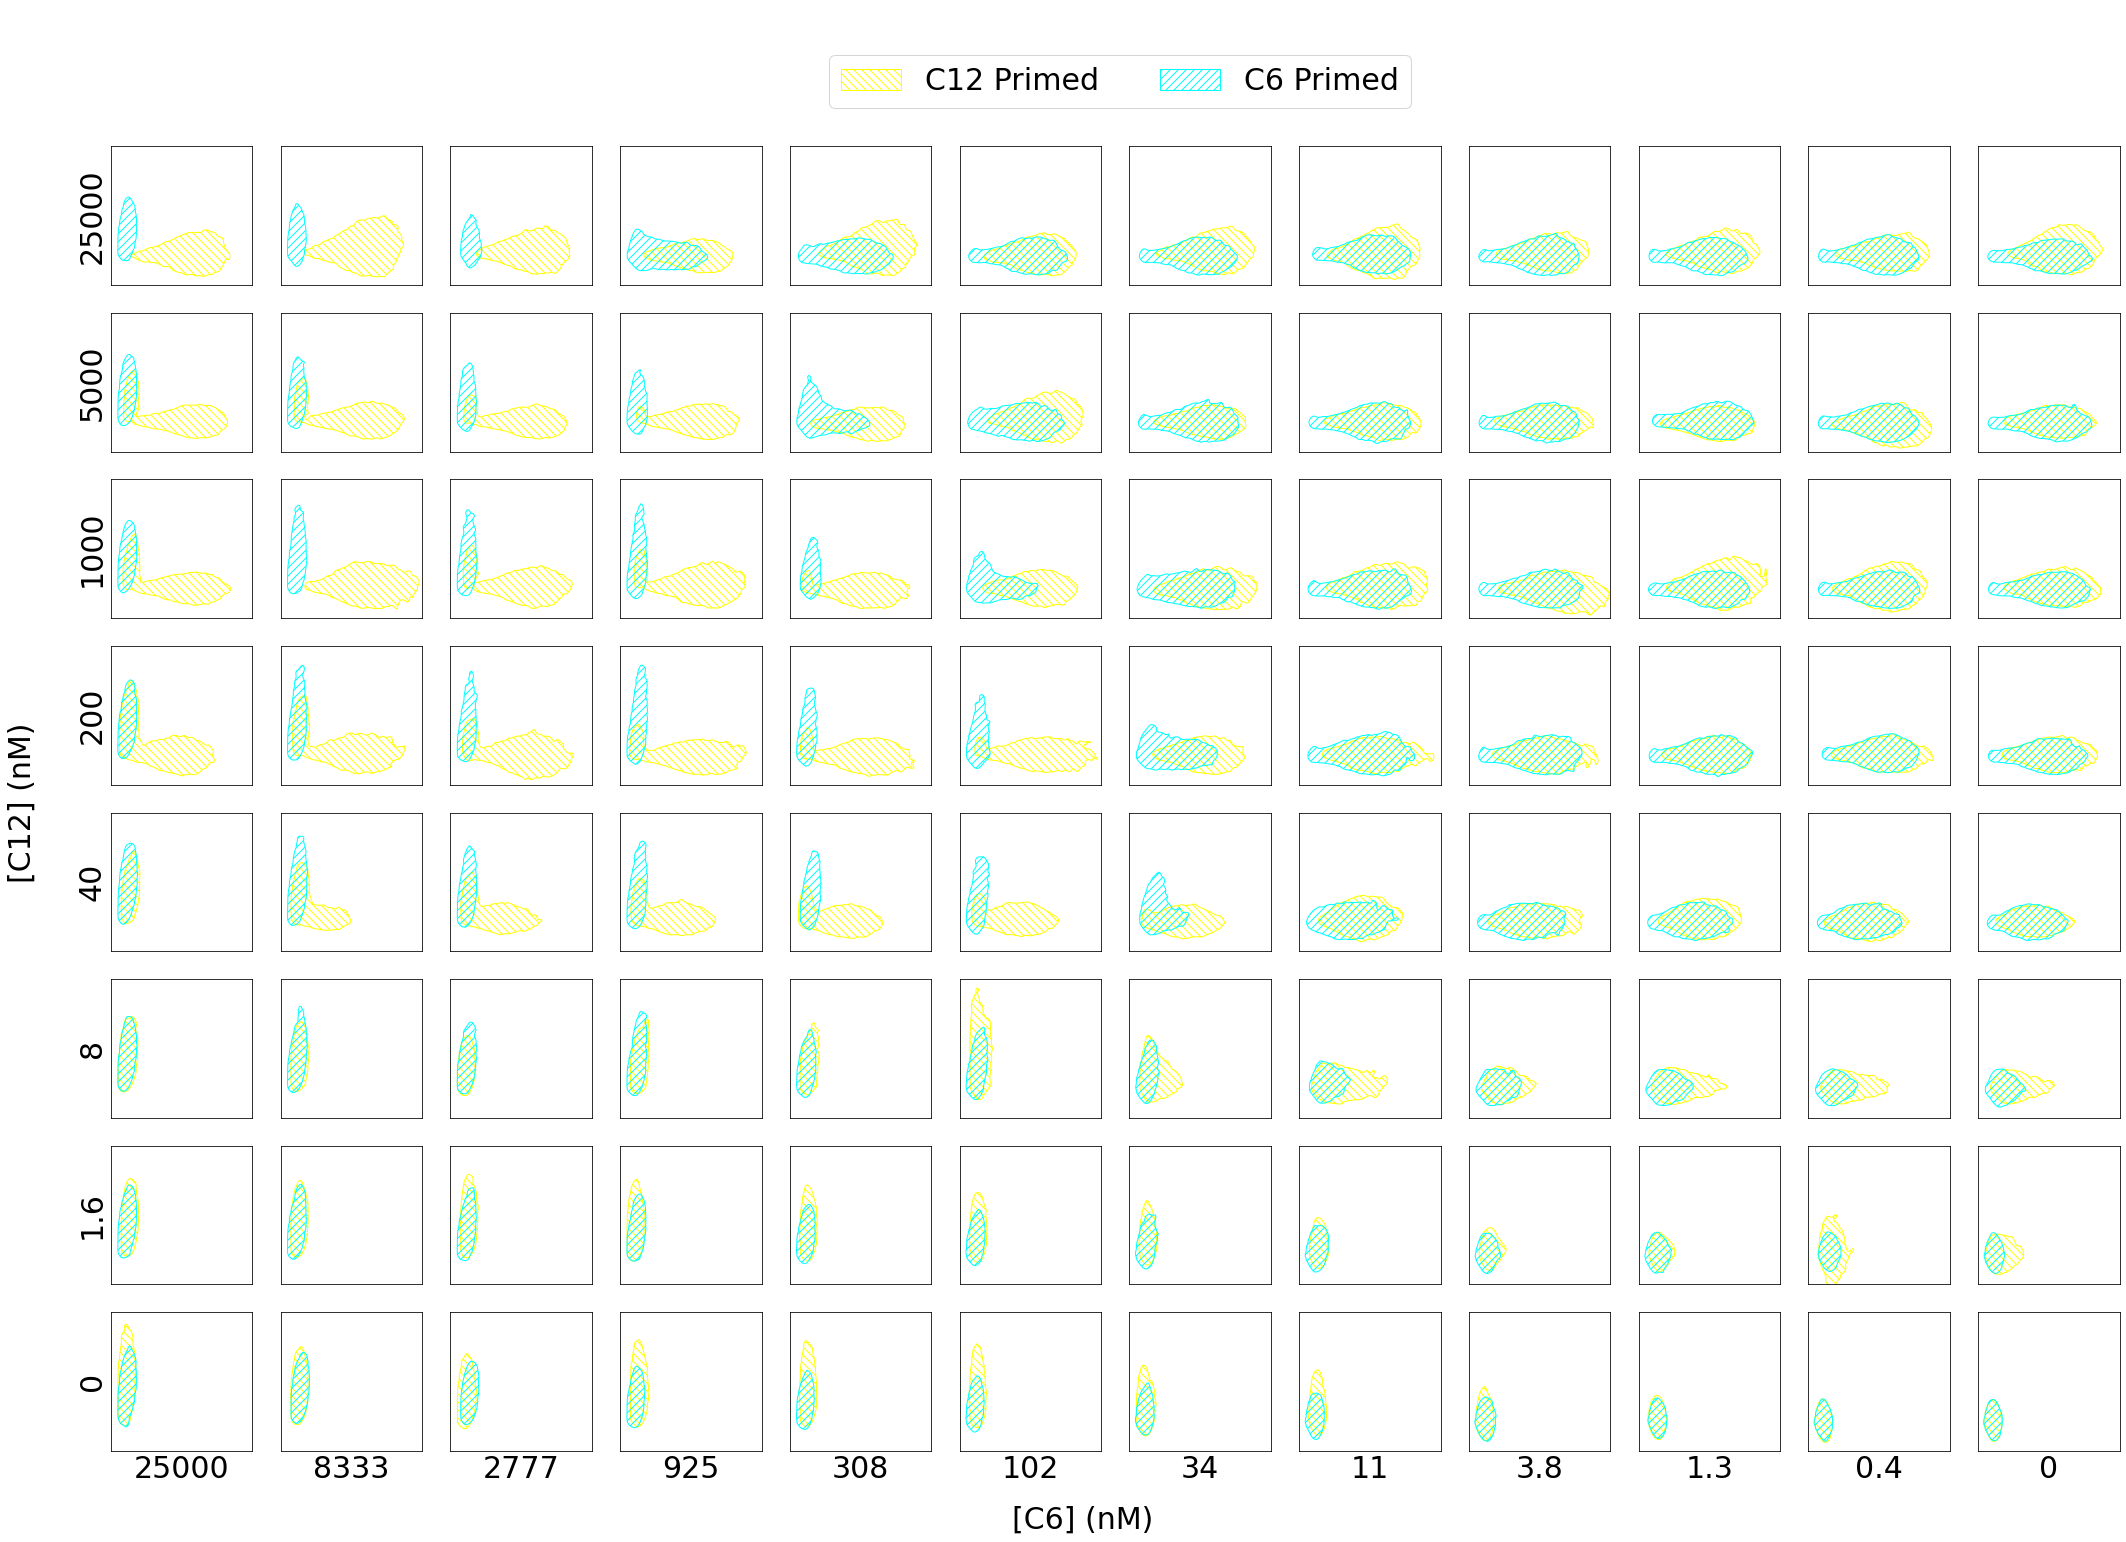

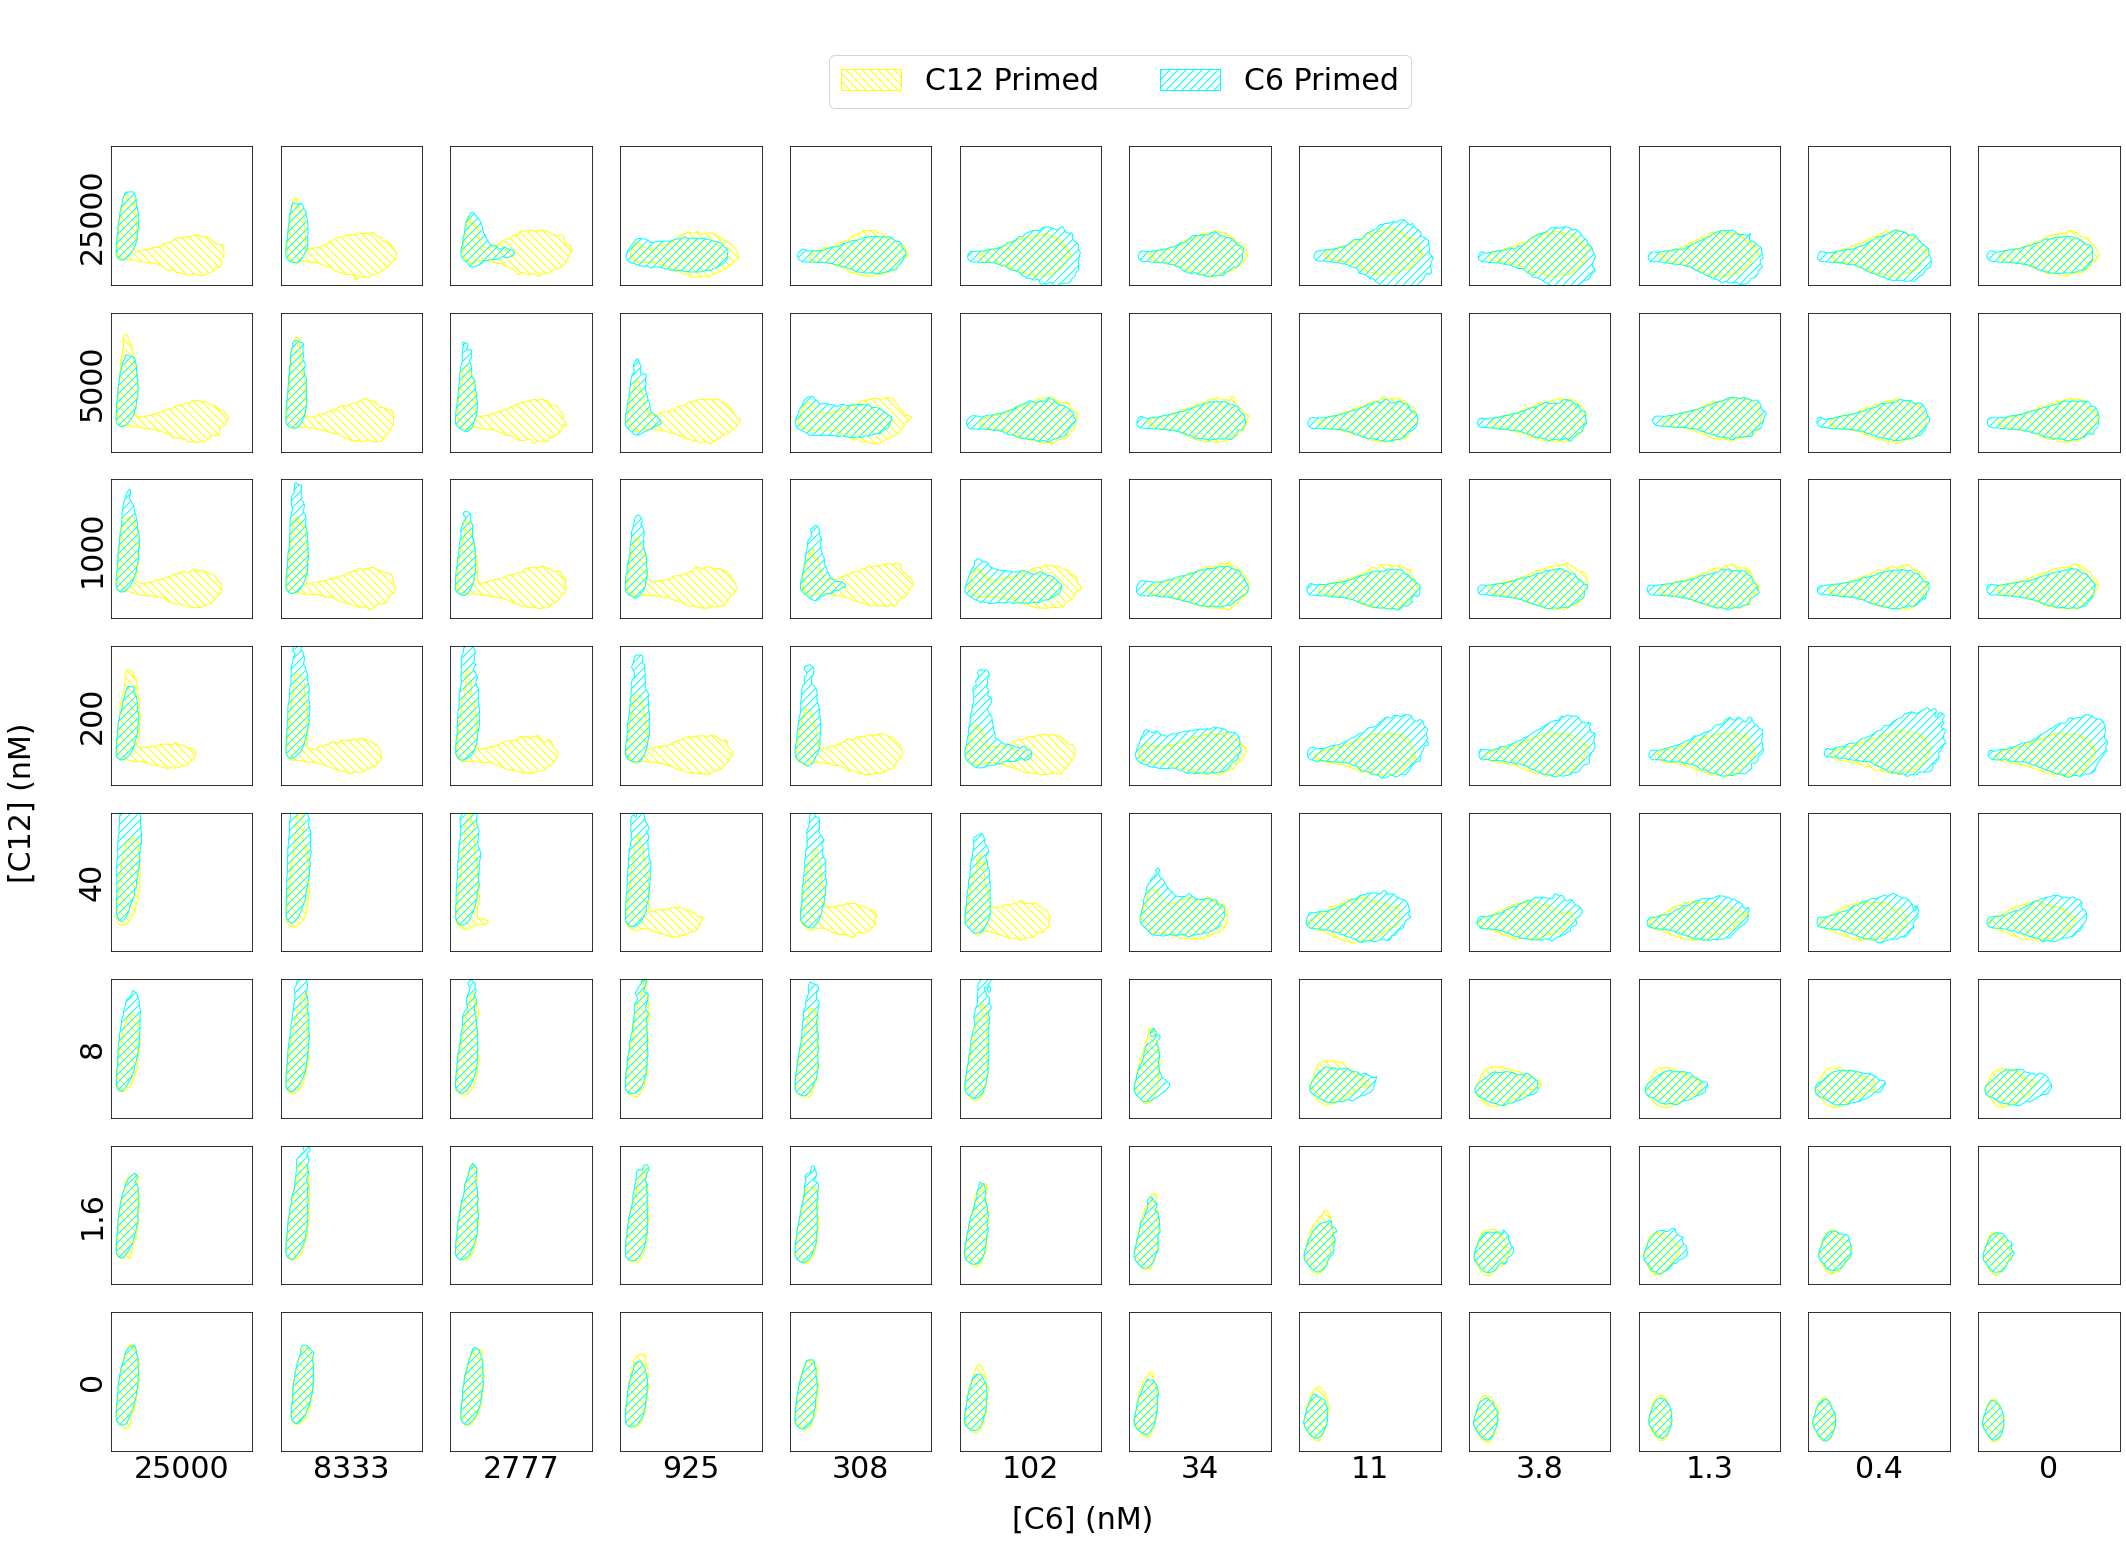

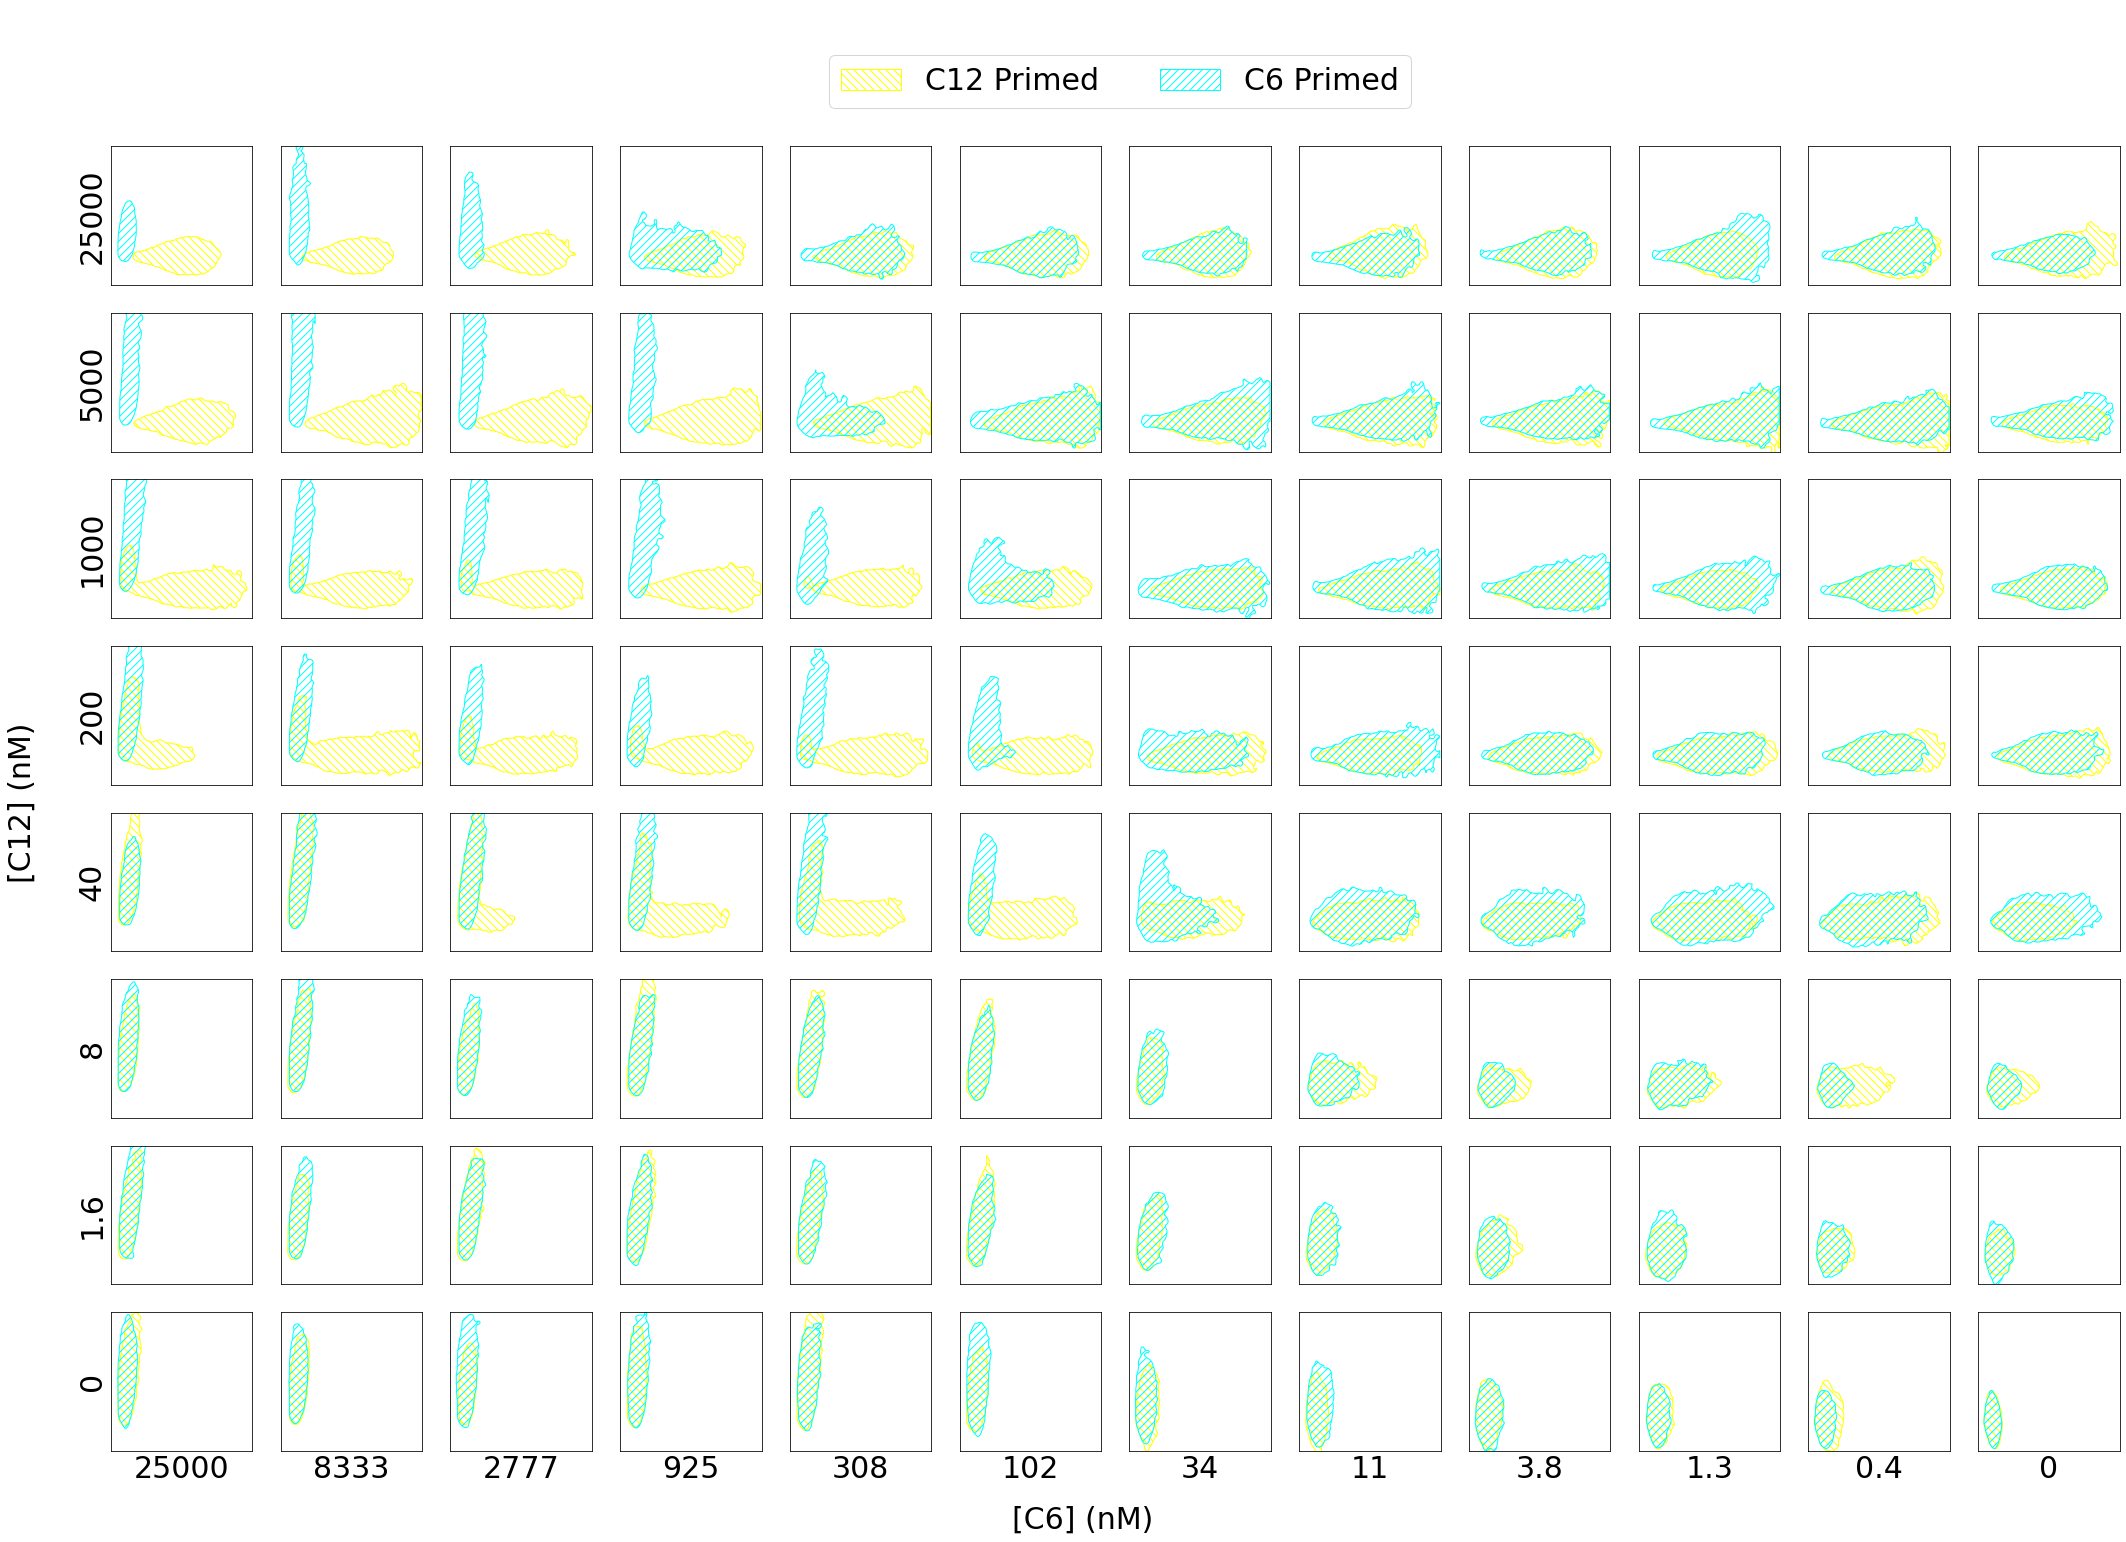

In [25]:
nrows,ncols = 8,12
bistability = zeros((3,nrows,ncols))
for batch in range(3) :

    fig, axs = subplots(nrows,ncols,
        figsize=(3*ncols,3*nrows),
        sharex=True,sharey=True)

    for idx in fcs.plates['C6'][batch]:

        i = list(fcs.row_layout.values()).index(idx[0])
        j = list(fcs.col_layout.values()).index(idx[1])+1
        ax = subplot(nrows,ncols,i*ncols+j)

        c12 = array([1,2])*fcs.plates['C12'][batch][idx].data[['Y','C']]
        c6 =  array([1,2])*fcs.plates['C6'][batch][idx].data[['Y','C']]
        
        c12 = c12.loc[~c12.isna().any(axis=1)]
        c6 = c6.loc[~c6.isna().any(axis=1)]
        
        c12 = Polygon( density_contour(c12.Y,c12.C),
            closed=True ,label='C12 Primed', fill=False, hatch='\\\\\\',color='yellow')
        
        c6 = Polygon( density_contour(c6.Y,c6.C),
            closed=True, label='C6 Primed', fill=False, hatch='///',color='cyan')
        
        ax.add_patch(c12)
        ax.add_patch(c6)
        
        c12 = ShapelyPolygon(c12.get_xy())
        c6 = ShapelyPolygon(c6.get_xy())
        
        bistability[batch,i,j-1] = 1-c12.intersection(c6).area/c12.union(c6).area

        ax.axes.set_xticks([])
        ax.axes.set_yticks([])

        ax.axes.set_xlim(-1/2,4/2)
        ax.axes.set_ylim(-1/4,5/2)
        
        if j == 1 :
            ax.axes.set_ylabel(idx[0],fontsize=30)
        if i == 7 :
            ax.axes.set_xlabel(idx[1],fontsize=30)
            
        handles,labels = ax.axes.get_legend_handles_labels()
    figlegend(handles, labels, loc=(0.39,0.93),ncol=2,fontsize=30) 

    fig.text(0.50, 0.08, '[C6] (nM)', ha='center', fontsize=30)
    fig.text(0.085, 0.50, '[C12] (nM)', va='center', fontsize=30, rotation='vertical')

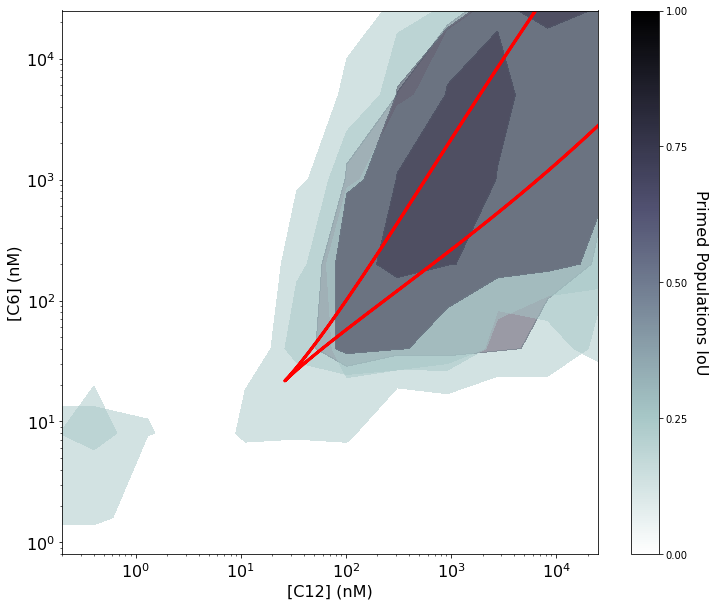

In [29]:
c12 = list(fcs.col_layout.values())
c6 = list(fcs.row_layout.values())
C12,C6 = meshgrid(c12,c6)

fig = figure(figsize=(12,10))
for batch in range(3) :
    contourf(C12,C6,bistability[batch],levels=[0.50,0.75,1.0],alpha=0.5,cmap='bone_r')

cbar = colorbar(ScalarMappable(norm=Normalize(vmin = 0, vmax = 1), cmap='bone_r'),
                ticks=[0,0.25,0.5,0.75,1])
cbar.set_label('Primed Populations IoU', rotation=270, fontsize=16, labelpad=20)

c12,c6 = genfromtxt('./../../output/limit-curve.csv',delimiter=',').T
plot(c12,c6,'r',linewidth=3)

xscale('log'); yscale('log')
xlim(2e-1,2.5e4); ylim(8e-1,2.5e4)

xlabel('[C12] (nM)',fontsize=16)
ylabel('[C6] (nM)',fontsize=16)

fig.axes[0].tick_params(axis='both', which='major', labelsize=16)
fig.axes[0].tick_params(axis='both', which='minor', labelsize=16)